In [1]:
# Running All Imports

import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import IBMQ, pulse

from qiskit.tools.monitor import job_monitor

from qiskit.visualization.pulse_v2 import stylesheet

from scipy.optimize import curve_fit

from typing import Optional

IBMQ.load_account()

/var/folders/g4/_yhz0jm50s17zz2ms7wwytcr0000gr/T/ipykernel_48812/2520264742.py:18: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
provider = IBMQ.get_provider(hub='ibm-q-nus', group='default', project='default')
provider.backends()

### KYOTO DETAILS ###
backend = provider.get_backend('ibm_kyoto') # replace the name with the exact one for the backend that is desired from the previous displayed backends
qubit = 2

In [3]:
DEBUG_PRINT = True

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt # Example way of getting data on the backend
backend_defaults = backend.defaults() 

acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

lcm = np.lcm(acquire_alignment, pulse_alignment)

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# Experiments will be run on these qubits
qubit_0 = 0
qubit_1 = 1

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz_0 = backend_defaults.qubit_freq_est[qubit_0]
center_frequency_Hz_1 = backend_defaults.qubit_freq_est[qubit_1]

meas_freq_0 = backend_defaults.meas_freq_est[qubit_0]
meas_freq_1 = backend_defaults.meas_freq_est[qubit_1]

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

instruction_schedule_map = backend.defaults().instruction_schedule_map
measure_instructions = np.array(instruction_schedule_map.get("measure", qubits=[qubit]).instructions)
measure_pulse = measure_instructions[-2,1].pulse
measure_delay = measure_instructions[-1,1]

x_instructions = np.array(instruction_schedule_map.get("x", qubits=[qubit]).instructions)
x_pulse = x_instructions[0,1].pulse

sx_instructions = np.array(instruction_schedule_map.get("sx", qubits=[qubit]).instructions)
sx_pulse = sx_instructions[0,1].pulse

if DEBUG_PRINT:
    print(f"config: {backend_config}")

    for key, value in backend_config.to_dict().items():
        print(key)
        print(value)
    
    print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                            # 1e9 to get nanoseconds

    backend_config.timing_constraints

    print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

    print(f"Qubit {qubit_0} has an estimated frequency of {center_frequency_Hz_0 / GHz} GHz.")
    print(f"Qubit {qubit_1} has an estimated frequency of {center_frequency_Hz_1 / GHz} GHz.")

    print(f"Resonator for qubit {qubit_0} has an estimated frequency of {meas_freq_0 / GHz} GHz.")
    print(f"Resonator for qubit {qubit_1} has an estimated frequency of {meas_freq_1 / GHz} GHz.")

    print(f"measure_instructions: {measure_instructions}")

    print(f"measurement pulse: {measure_pulse}")
    print(f"measurement delay: {measure_delay}")
    print(f"x pulse: {x_pulse}")
    print(f"sx pulse: {sx_pulse}")

config: <qiskit.providers.models.backendconfiguration.PulseBackendConfiguration object at 0x7fbbd8fd2e20>
backend_name
ibm_kyoto
backend_version
1.2.38
n_qubits
127
basis_gates
['id', 'rz', 'sx', 'x', 'ecr', 'reset']
gates
[{'name': 'id', 'parameters': [], 'qasm_def': 'gate id q { U(0, 0, 0) q; }', 'coupling_map': [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [1

## Measuring Photon Population using AC Stark Shift

In [4]:
center_freq = -15.0 * MHz
freq_span = 40.0 * MHz
num_exps = 126
ac_ss_freq_linspace = np.linspace(-0.5 * freq_span, 0.5 * freq_span, num_exps) + center_freq

ss_reset_delay_dt = 2 * measure_delay.duration

print(ac_ss_freq_linspace/MHz)

[-35.   -34.68 -34.36 -34.04 -33.72 -33.4  -33.08 -32.76 -32.44 -32.12
 -31.8  -31.48 -31.16 -30.84 -30.52 -30.2  -29.88 -29.56 -29.24 -28.92
 -28.6  -28.28 -27.96 -27.64 -27.32 -27.   -26.68 -26.36 -26.04 -25.72
 -25.4  -25.08 -24.76 -24.44 -24.12 -23.8  -23.48 -23.16 -22.84 -22.52
 -22.2  -21.88 -21.56 -21.24 -20.92 -20.6  -20.28 -19.96 -19.64 -19.32
 -19.   -18.68 -18.36 -18.04 -17.72 -17.4  -17.08 -16.76 -16.44 -16.12
 -15.8  -15.48 -15.16 -14.84 -14.52 -14.2  -13.88 -13.56 -13.24 -12.92
 -12.6  -12.28 -11.96 -11.64 -11.32 -11.   -10.68 -10.36 -10.04  -9.72
  -9.4   -9.08  -8.76  -8.44  -8.12  -7.8   -7.48  -7.16  -6.84  -6.52
  -6.2   -5.88  -5.56  -5.24  -4.92  -4.6   -4.28  -3.96  -3.64  -3.32
  -3.    -2.68  -2.36  -2.04  -1.72  -1.4   -1.08  -0.76  -0.44  -0.12
   0.2    0.52   0.84   1.16   1.48   1.8    2.12   2.44   2.76   3.08
   3.4    3.72   4.04   4.36   4.68   5.  ]


126


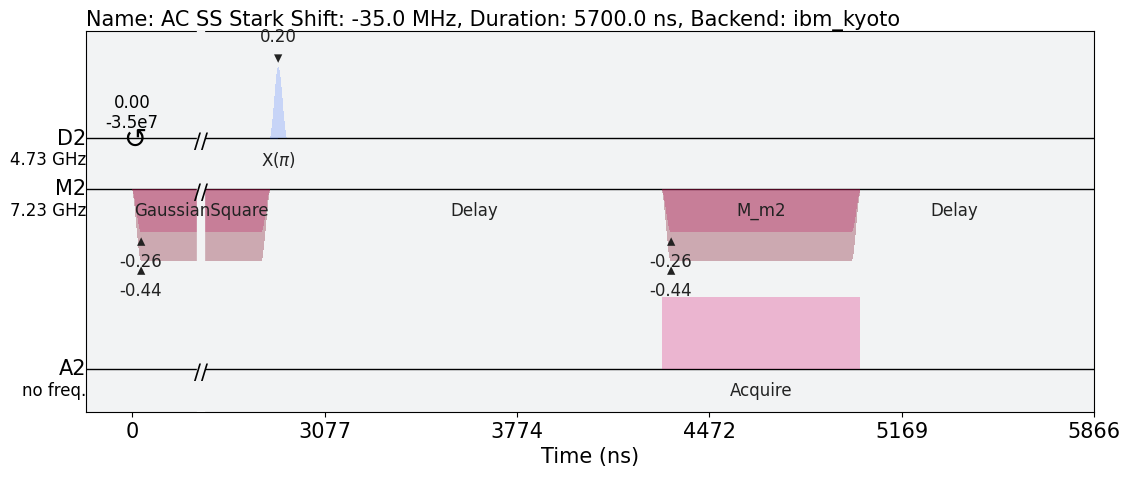

In [5]:
ac_ss_freq_jobs = []

ac_ss_meas_duration = 4 * measure_pulse.duration

ac_ss_meas_pulse = pulse.GaussianSquare(
    duration=ac_ss_meas_duration,
    amp=measure_pulse.amp,
    sigma=measure_pulse.sigma,
    width=ac_ss_meas_duration - 4 * measure_pulse.sigma,
    angle=measure_pulse.angle
)

for freq_shift in ac_ss_freq_linspace:
    with pulse.build(
        backend=backend,
        default_alignment='sequential',
        name=f'AC SS Stark Shift: {np.round(freq_shift/MHz, 1)} MHz'
    ) as ac_ss_freq_sched:
        qubit_chan = pulse.drive_channel(qubit)
        meas_chan = pulse.measure_channel(qubit)

        pulse.shift_frequency(freq_shift, qubit_chan)
        pulse.play(ac_ss_meas_pulse, meas_chan)
        pulse.play(x_pulse, qubit_chan)
        pulse.delay(ss_reset_delay_dt, meas_chan)
        pulse.measure(qubit, pulse.MemorySlot(qubit))
    
    ac_ss_freq_jobs.append(ac_ss_freq_sched)

print(len(ac_ss_freq_jobs))

ac_ss_freq_jobs[0].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

## RR Kappa Measurement with AC Stark Shift Meas

In [7]:
from utils import convert_arr_to_dt
kappa_freq_span = 40. * MHz
kappa_center = -10. * MHz

num_kappa_exp = 5
qubit_delay_t0 = 0. * ns
qubit_delay_t1 = 0.5 * measure_delay.duration * dt
kappa_qubit_delays = np.linspace(qubit_delay_t0, qubit_delay_t1, num_kappa_exp)
kappa_qubit_delays = convert_arr_to_dt(kappa_qubit_delays, dt)

num_freq_exps = 91
kappa_freq_linspace = np.linspace(-0.5 * kappa_freq_span, 0.5 * kappa_freq_span, num_freq_exps) + kappa_center

kappa_reset_delay_dt = measure_delay.duration
print(kappa_qubit_delays/ns)
print(kappa_freq_linspace/MHz)

[  0.  88. 168. 256. 336.]
[-30.         -29.55555556 -29.11111111 -28.66666667 -28.22222222
 -27.77777778 -27.33333333 -26.88888889 -26.44444444 -26.
 -25.55555556 -25.11111111 -24.66666667 -24.22222222 -23.77777778
 -23.33333333 -22.88888889 -22.44444444 -22.         -21.55555556
 -21.11111111 -20.66666667 -20.22222222 -19.77777778 -19.33333333
 -18.88888889 -18.44444444 -18.         -17.55555556 -17.11111111
 -16.66666667 -16.22222222 -15.77777778 -15.33333333 -14.88888889
 -14.44444444 -14.         -13.55555556 -13.11111111 -12.66666667
 -12.22222222 -11.77777778 -11.33333333 -10.88888889 -10.44444444
 -10.          -9.55555556  -9.11111111  -8.66666667  -8.22222222
  -7.77777778  -7.33333333  -6.88888889  -6.44444444  -6.
  -5.55555556  -5.11111111  -4.66666667  -4.22222222  -3.77777778
  -3.33333333  -2.88888889  -2.44444444  -2.          -1.55555556
  -1.11111111  -0.66666667  -0.22222222   0.22222222   0.66666667
   1.11111111   1.55555556   2.           2.44444444   2.88888889

455


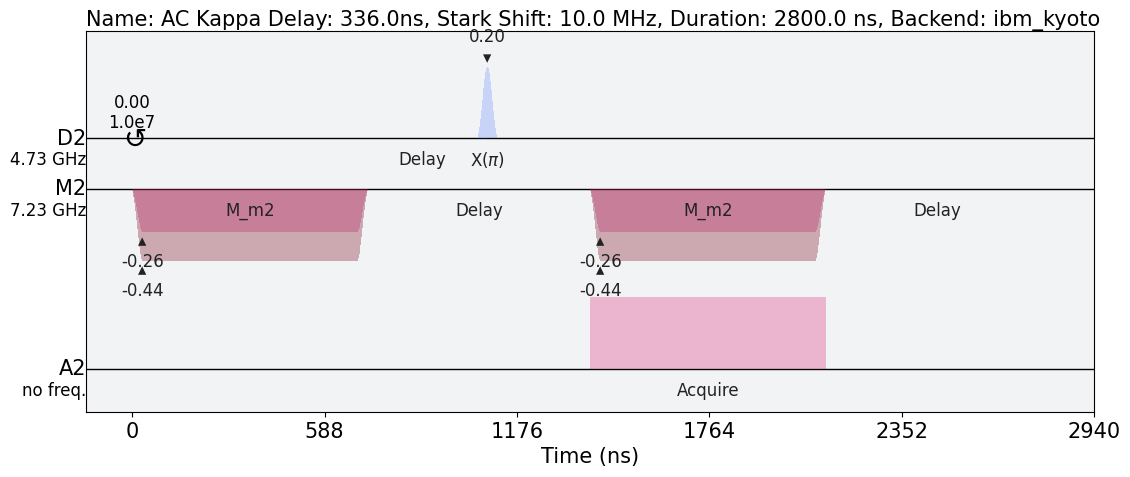

In [9]:
from utils import get_dt_from

kappa_jobs = []

for qubit_delay_ns in kappa_qubit_delays:
    ac_freq_jobs = []
    qubit_delay_dt = get_dt_from(qubit_delay_ns, dt)

    for freq_shift in kappa_freq_linspace:
        with pulse.build(
            backend=backend,
            default_alignment='sequential',
            name=f'AC Kappa Delay: {np.round(qubit_delay_ns/ns, 3)}ns, Stark Shift: {np.round(freq_shift/MHz, 1)} MHz'
        ) as ac_freq_sched:
            qubit_chan = pulse.drive_channel(qubit)
            meas_chan = pulse.measure_channel(qubit)

            pulse.shift_frequency(freq_shift, qubit_chan)
            pulse.play(measure_pulse, meas_chan)
            with pulse.align_left():
                pulse.delay(qubit_delay_dt, qubit_chan)
                pulse.play(x_pulse, qubit_chan)
                pulse.delay(kappa_reset_delay_dt, meas_chan)
            pulse.measure(qubit, pulse.MemorySlot(qubit))
        
        ac_freq_jobs.append(ac_freq_sched)
    
    kappa_jobs += ac_freq_jobs

print(len(kappa_jobs))

kappa_jobs[-1].draw(
    backend=backend,
    style=stylesheet.IQXDebugging(),
    show_framechange=True,
    show_waveform_info=True,
    show_barrier=True,
)

In [10]:
from utils import acquisition_checker

big_job = ac_ss_freq_jobs + kappa_jobs
job_1 = big_job[:290]
job_2 = big_job[290:]

num_shots = 8192
rep_delay = 499. * us

acquisition_checker(job_1, backend)
acquisition_checker(job_2, backend)

print(len(job_1))
print(len(job_2))

290
291


In [12]:
# Running job_1, job_2

job_experiment = backend.run(job_2, 
                            meas_level=1, 
                            meas_return='single', 
                            shots=num_shots,
                            rep_delay=rep_delay)

job_monitor(job_experiment)

Job Status: job is queued

KeyboardInterrupt: 

In [ ]:
job_1 = provider.backend.retrieve_job(job_id='crx7xyqx484g008ffv7g') # Queue
job_2 = provider.backend.retrieve_job(job_id='crx7y1r7jqmg008zssm0') # Queue